In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest # for Kolmogorov-Smirnov test
from scipy.stats import f_oneway # for ANOVA test
from scipy.stats import chi2_contingency # for Chi-square test
import itertools # for combinations 

## 1. Chargement et Inspection des Données

In [2]:
# Load the dataset
df_train = pd.read_csv('../data/brut_data.csv')

In [3]:
# Explore the dataset
# Display the first few rows of the dataset
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15713774.0,Hsieh,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,1.0
1,1,15682533.0,Hs?eh,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,0.0
2,2,15791550.0,Tsou,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,0.0
3,3,15762762.0,Chiawuotu,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,0.0
4,4,15756475.0,Nnamdi,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,0.0


In [4]:
# Display the shape of the dataset
df_train.shape

(15000, 14)

In [5]:
# Display the data types of the columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [6]:
# Display the percentage of missing values in each column
df_train.isna().mean()*100  

id                 0.0
CustomerId         0.0
Surname            0.0
CreditScore        0.0
Geography          0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

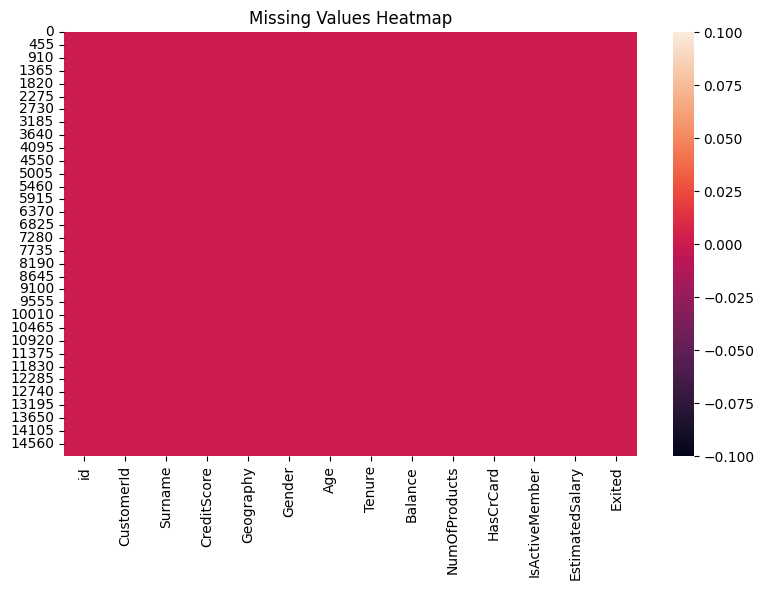

In [7]:
# Visualize missing values heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_train.isnull(), cbar=True)
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.show()

In [8]:
# Display the sum of duplicated 
df_train.duplicated().sum()

0

### Analyse de la Variable Cible (Target)

#### Définition:
La variable **Exited** est notre cible:
- **0**: Client qui reste (Non-churn)
- **1**: Client qui part (Churn)

In [9]:
# Select Target variable
#Y = df_train['Exited']
#df_train.drop(columns=['Exited'], inplace=True)

In [10]:
df_train['Exited'] = df_train['Exited'].astype('int')

In [11]:
# Target variable 
df_train['Exited'].value_counts()

Exited
0    12010
1     2990
Name: count, dtype: int64

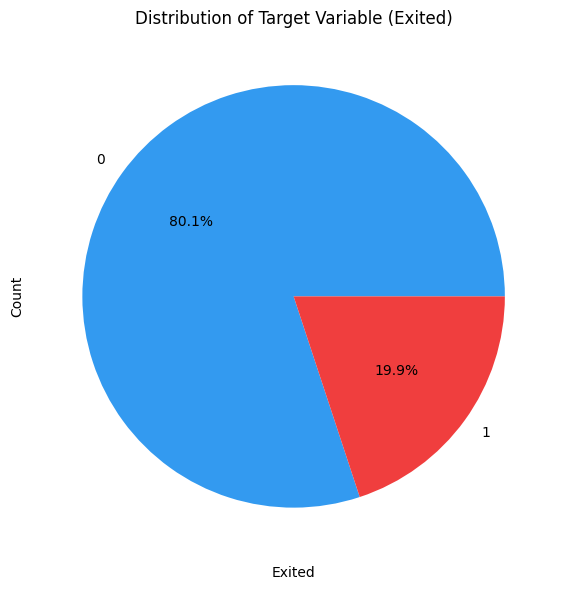

In [12]:
plt.figure(figsize=(8, 6))
df_train['Exited'].value_counts().plot(kind='pie',autopct='%1.1f%%', colors=['#339af0', '#f03e3e'])
plt.title('Distribution of Target Variable (Exited)')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Nettoyage et Préparation

**ID, Surname, CustomerId**: Identifiants uniques, sans pouvoir prédictif


In [13]:
# Drop unnecessary columns
df_train.drop(['id','Surname','CustomerId'],axis=1, inplace=True)

In [14]:
# display the shape of the dataset after dropping columns
df_train.shape

(15000, 11)

In [15]:
# Select numerical variables
var_num = df_train.select_dtypes(include=['int', 'float'])
# Select categorical variables
var_cat = df_train.select_dtypes(include=['object','category'])

In [16]:
# Display the columns of numerical and categorical variables
display(var_num.columns)
display(var_cat.columns)

# Count of numerical and categorical variables
count_data_train = var_num + var_cat
display(count_data_train.shape)

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

Index(['Geography', 'Gender'], dtype='object')

(15000, 11)

In [17]:
# Display descriptive statistics for numerical variables
print("Descriptive Statistics for Numerical Variables:")
display(var_num.describe().T)
# Display descriptive statistics for categorical variables
print("Descriptive Statistics for Categorical Variables:")
display(var_cat.describe().T)

Descriptive Statistics for Numerical Variables:


,count,mean,std,min,25%,50%,75%,max
CreditScore,15000.0,658.701800,80.238346,431.00,602.00,661.00,709.00,4818.00
Age,15000.0,37.660800,8.106408,18.00,32.00,37.00,42.00,72.00
Tenure,15000.0,5.038800,2.810354,0.00,3.00,5.00,7.00,10.00
Balance,15000.0,42888.826095,59695.877791,0.00,0.00,0.00,109844.81,207034.96
NumOfProducts,15000.0,1.589467,0.532430,1.00,1.00,2.00,2.00,6.00
HasCrCard,15000.0,0.779800,0.414395,0.00,1.00,1.00,1.00,1.00
IsActiveMember,15000.0,0.497867,0.500012,0.00,0.00,0.00,1.00,1.00
EstimatedSalary,15000.0,117892.175400,45574.462515,11.58,82870.75,123583.85,157567.37,199761.29
Exited,15000.0,0.199333,0.399512,0.00,0.00,0.00,0.00,1.00


Descriptive Statistics for Categorical Variables:


,count,unique,top,freq
Geography,15000,3,France,9048
Gender,15000,2,Male,8422


In [18]:
# Count unique values in numerical variables
display(var_num.nunique())
# Count unique values in categorical variables
display(var_cat.nunique())

CreditScore         376
Age                  55
Tenure               11
Balance            3307
NumOfProducts         5
HasCrCard             2
IsActiveMember        2
EstimatedSalary    6208
Exited                2
dtype: int64

Geography    3
Gender       2
dtype: int64

### Investigastion 

In [19]:
df_train['CreditScore'].value_counts().unique()

array([251, 197, 181, 170, 166, 159, 156, 150, 147, 146, 143, 141, 136,
       135, 130, 126, 122, 120, 118, 117, 115, 114, 113, 111, 110, 108,
       106, 104, 102, 100,  99,  98,  97,  96,  92,  91,  90,  89,  88,
        87,  86,  85,  84,  82,  81,  80,  79,  78,  76,  75,  73,  72,
        71,  70,  69,  68,  67,  66,  65,  64,  63,  62,  61,  60,  59,
        58,  56,  55,  54,  52,  51,  50,  49,  48,  47,  46,  45,  44,
        43,  42,  41,  40,  39,  38,  37,  35,  33,  32,  31,  30,  29,
        27,  26,  25,  24,  22,  21,  20,  19,  18,  17,  15,  14,  13,
        12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1],
      dtype=int64)

In [20]:
df_train['Age'].value_counts().unique()

array([879, 845, 838, 819, 796, 793, 757, 738, 708, 695, 593, 557, 537,
       482, 478, 403, 376, 358, 324, 295, 247, 241, 218, 190, 185, 165,
       150, 140, 137, 109, 103,  91,  85,  76,  75,  74,  57,  50,  46,
        43,  41,  37,  30,  27,  25,  17,  16,  13,  11,  10,   9,   5,
         3,   2,   1], dtype=int64)

In [21]:
df_train['Age'].value_counts().max()

879

## 2. Analyse Univariée - Caractéristiques de chaque Variable

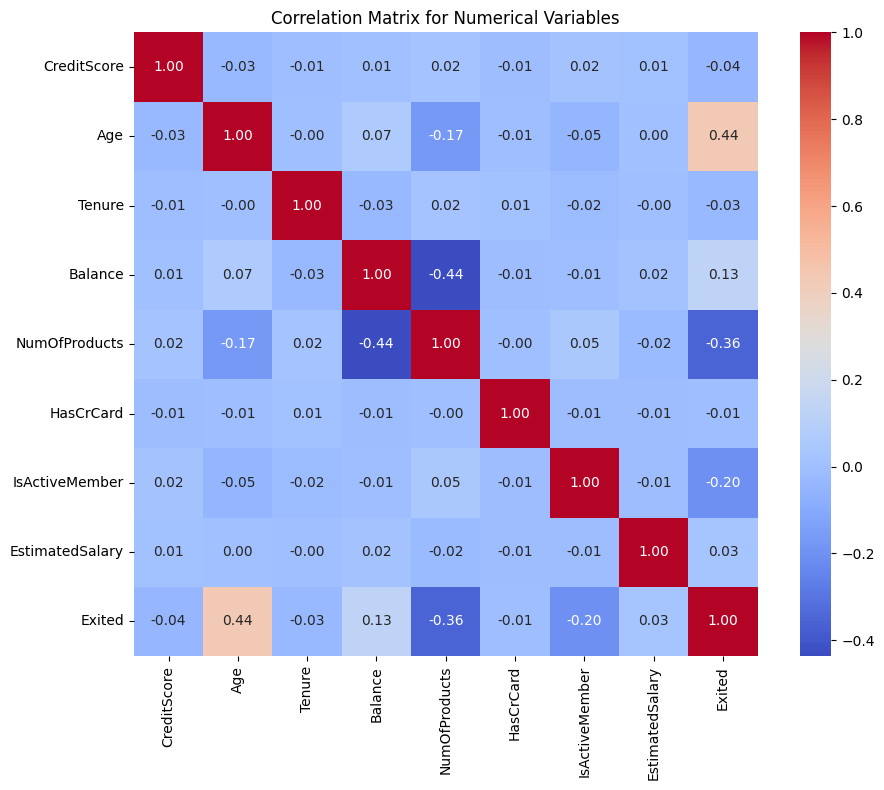

In [22]:
# Correlation matrix for numerical variables
plt.figure(figsize=(10, 8))
corr = var_num.corr('spearman')
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix for Numerical Variables')
plt.tight_layout()
plt.show()

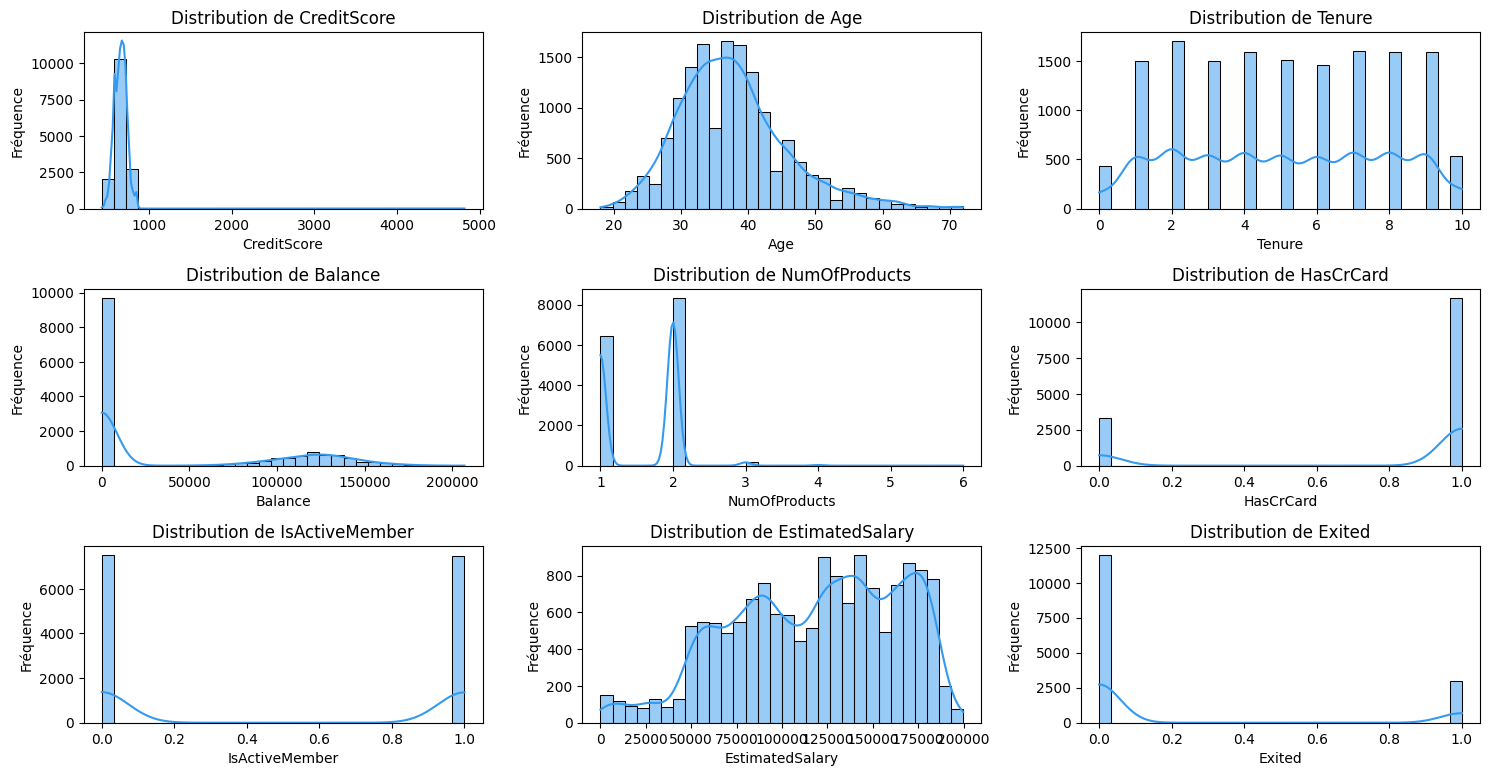

In [23]:
# Display distribution of numerical variables

plt.figure(figsize=(15, 10))
for i, column in enumerate(var_num, 1):
    plt.subplot(4, 3, i)  # 3 lignes, 2 colonnes
    sns.histplot(var_num[column], kde=True, bins=30 , color='#339af0')
    plt.title(f'Distribution de {column}')
    plt.xlabel(column)
    plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

In [24]:

results = []

for col in var_num.columns:
    data = df_train[col].dropna()

    # Normalization 
    data_norm = (data - data.mean()) / data.std()

    # KS test vs normal distribution
    ks_stat, p_value = kstest(data_norm, 'norm')

    # Conclusion on normality
    is_normal = "Yes" if p_value >= 0.05 else "No"

    results.append([col, ks_stat, p_value, is_normal])

# Final results DataFrame
ks_df = pd.DataFrame(results, columns=["Variable", "KS_statistic", "p_value", "Is_Normal"])
ks_df

,Variable,KS_statistic,p_value,Is_Normal
0,CreditScore,0.041210,1.428066e-22,No
1,Age,0.085458,9.361310e-96,No
2,Tenure,0.111231,4.256902e-162,No
3,Balance,0.411762,0.000000e+00,No
4,NumOfProducts,0.351263,0.000000e+00,No
5,HasCrCard,0.482221,0.000000e+00,No
6,IsActiveMember,0.342438,0.000000e+00,No
7,EstimatedSalary,0.063333,9.496619e-53,No
8,Exited,0.491756,0.000000e+00,No


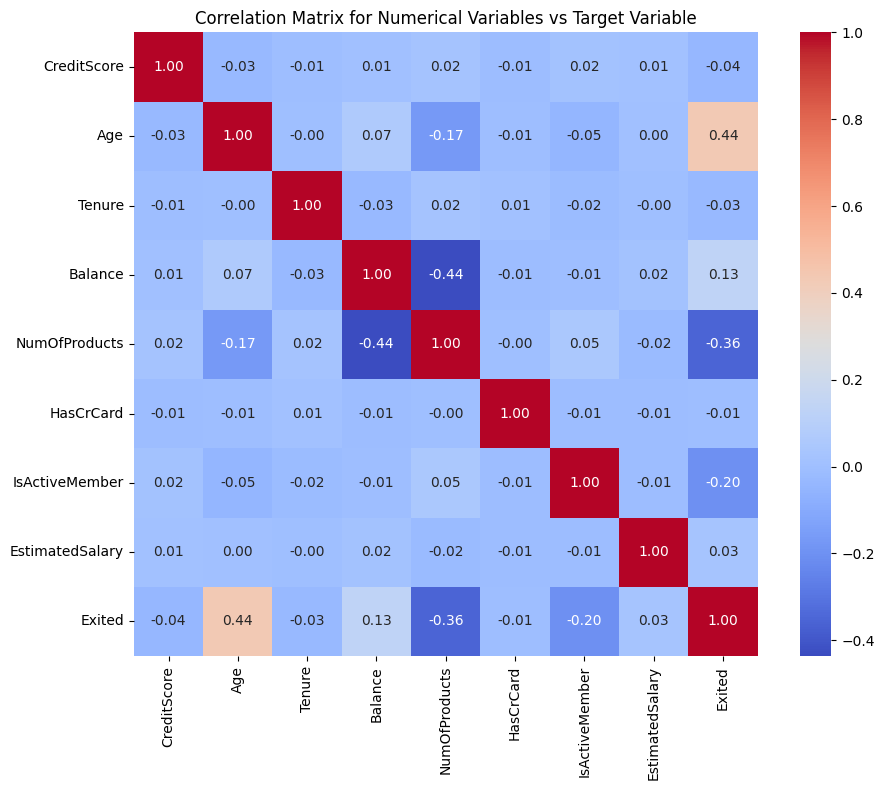

In [25]:
# Correlation matrix for numerical variables vs target variable
plt.figure(figsize=(10, 8)) 
corr_target = var_num.copy()
corr_target['Exited'] = df_train['Exited']
corr = corr_target.corr('spearman')
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix for Numerical Variables vs Target Variable')
plt.tight_layout()
plt.show()

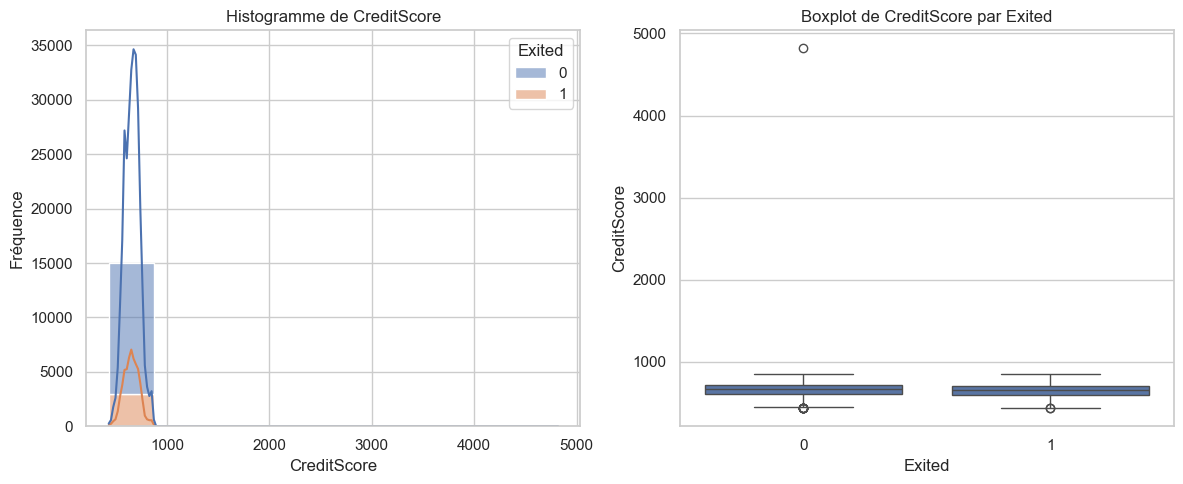

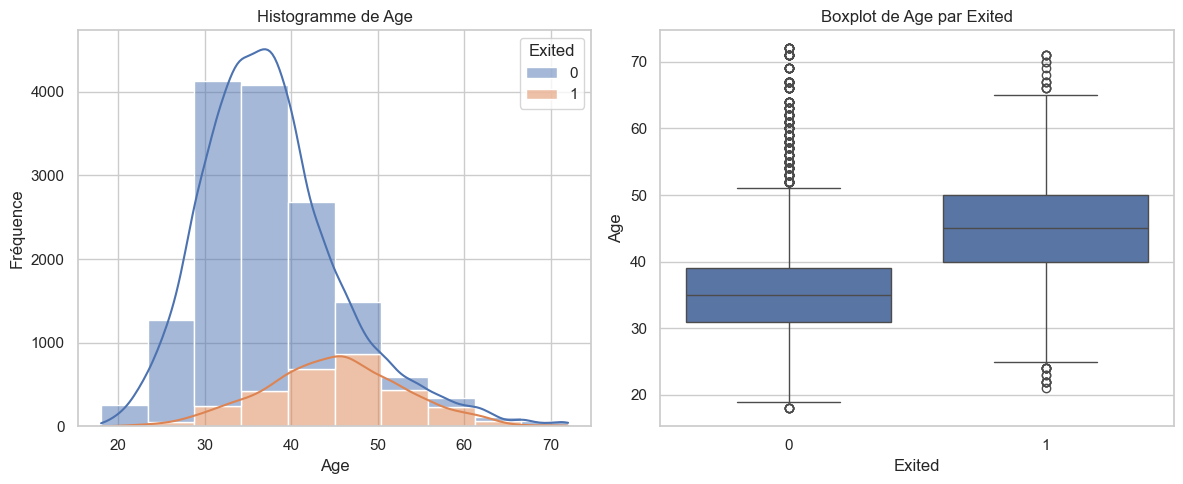

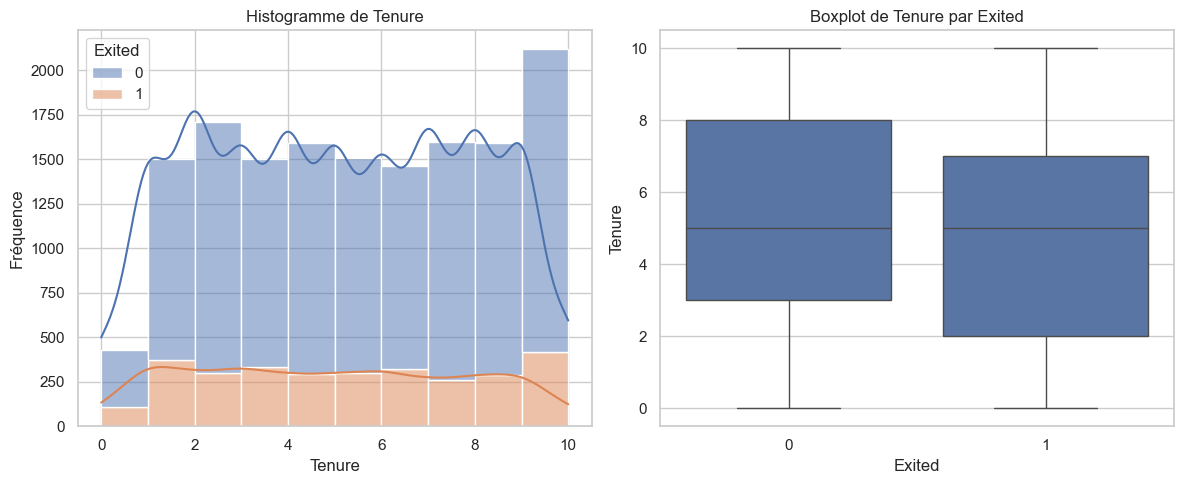

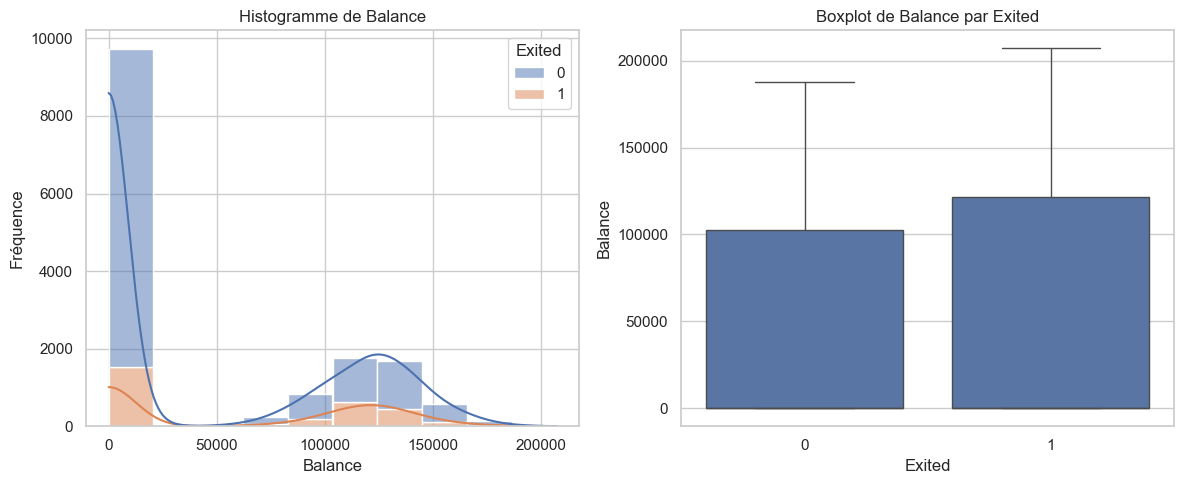

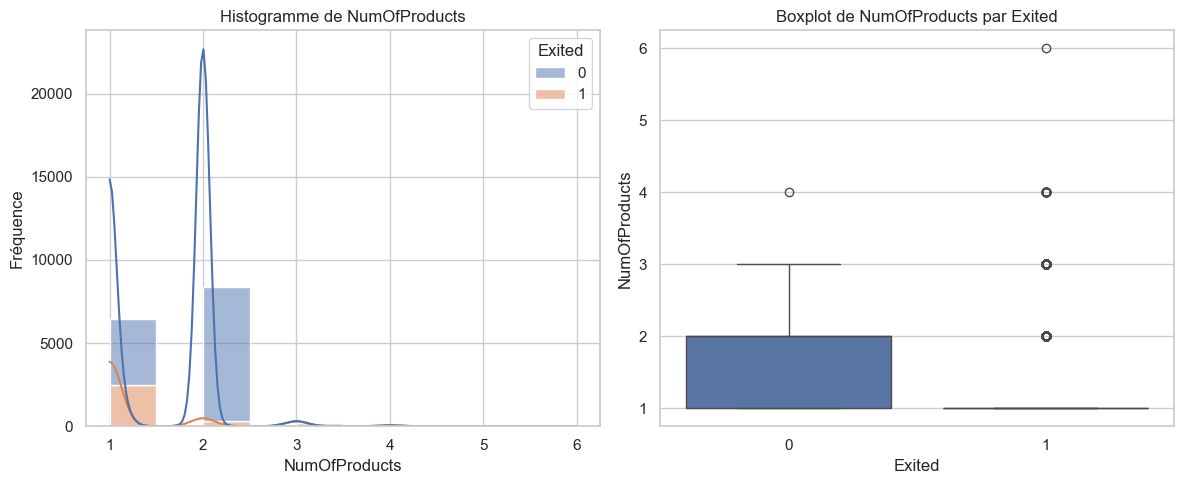

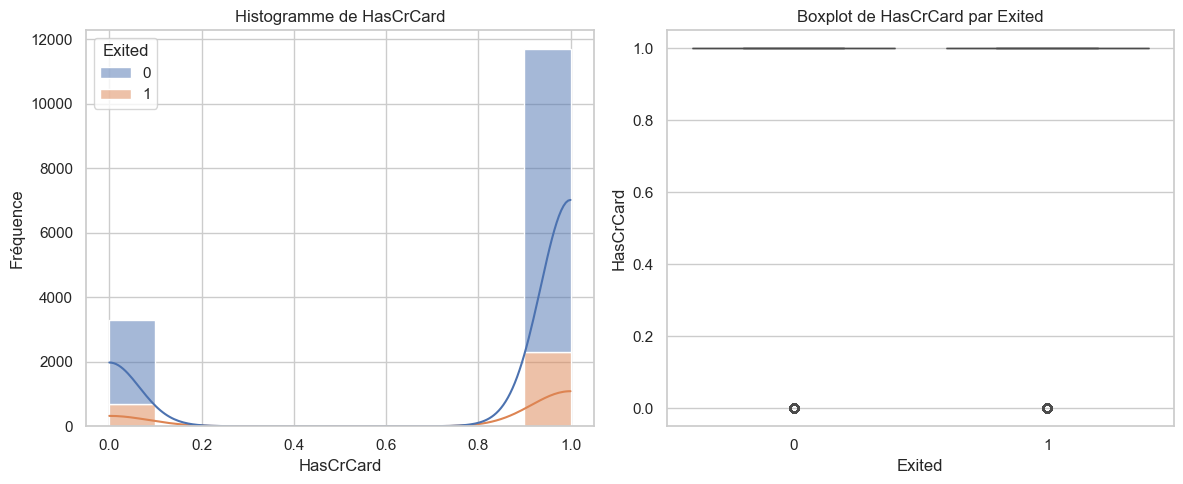

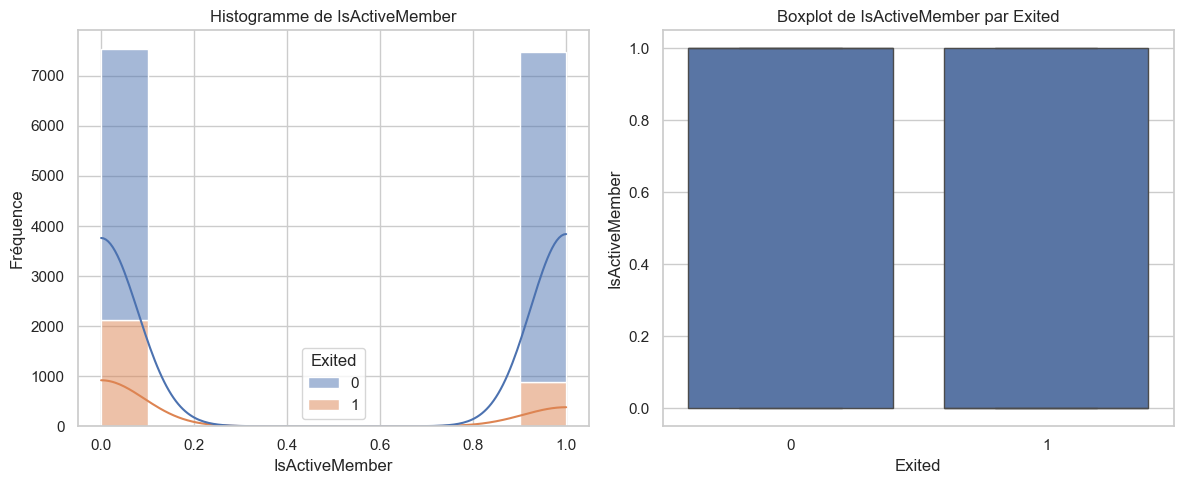

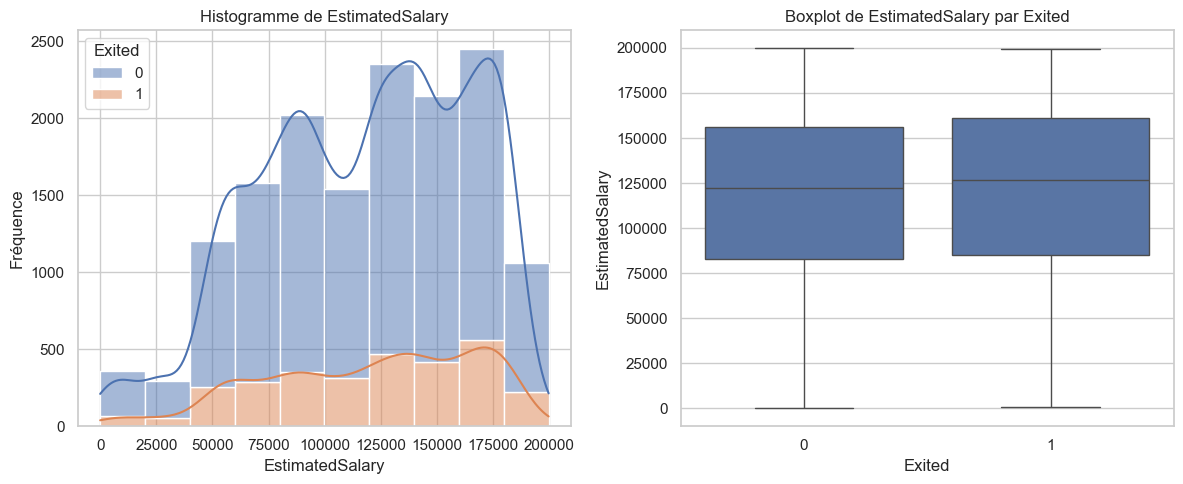

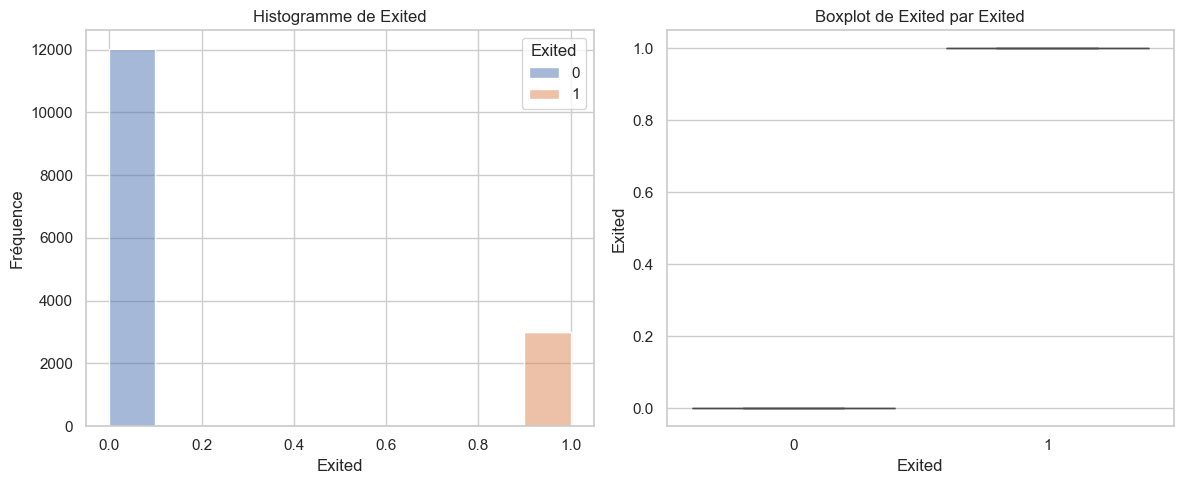

In [26]:
# Distribution des variables en fonction de la target
sns.set(style="whitegrid")

# Tracer un histogramme et un boxplot pour chaque variable numérique
for feature in var_num:
    plt.figure(figsize=(12, 5))

    # Histogramme
    plt.subplot(1, 2, 1)
    sns.histplot(df_train, x=feature, hue=df_train['Exited'], multiple="stack", bins=10, kde=True)
    plt.title(f'Histogramme de {feature}')
    plt.xlabel(feature)
    plt.ylabel('Fréquence')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_train['Exited'], y=feature, data=df_train)
    plt.title(f'Boxplot de {feature} par Exited')
    plt.xlabel('Exited')
    plt.ylabel(feature)

    plt.tight_layout()
    plt.show()

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_2236\1860381431.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=temp_df, x=column, hue='Exited', common_norm=False, fill=True, palette='crest', alpha=0.5)


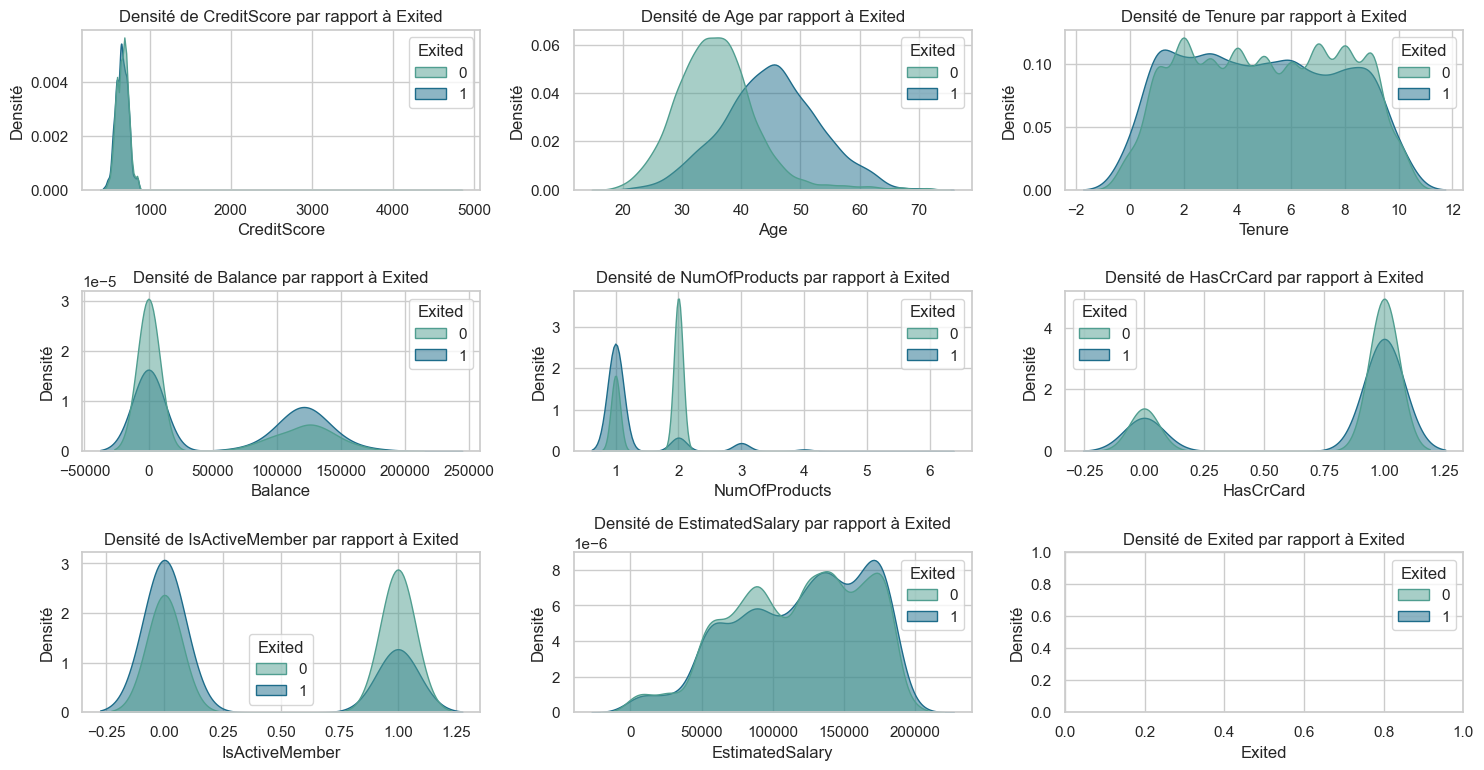

In [27]:
# Focus sur la densité des variables
plt.figure(figsize=(15, 10))

for i, column in enumerate(var_num.columns, 1):
    plt.subplot(4, 3, i)
    # Create a temporary DataFrame with the column and target variable
    temp_df = pd.DataFrame({column: df_train[column], 'Exited': df_train['Exited']})
    sns.kdeplot(data=temp_df, x=column, hue='Exited', common_norm=False, fill=True, palette='crest', alpha=0.5)
    plt.title(f'Densité de {column} par rapport à Exited')
    plt.xlabel(column)
    plt.ylabel('Densité')

plt.tight_layout()
plt.show()


## 4. Analyse Bivariée - Variables Catégoriques

### Analyse des Variables Catégoriques

#### Concepts:
- **Variable Catégorique**: Variable qui prend un nombre limité de valeurs distinctes
- **Distribution de fréquence**: Compte le nombre d'observations pour chaque catégorie

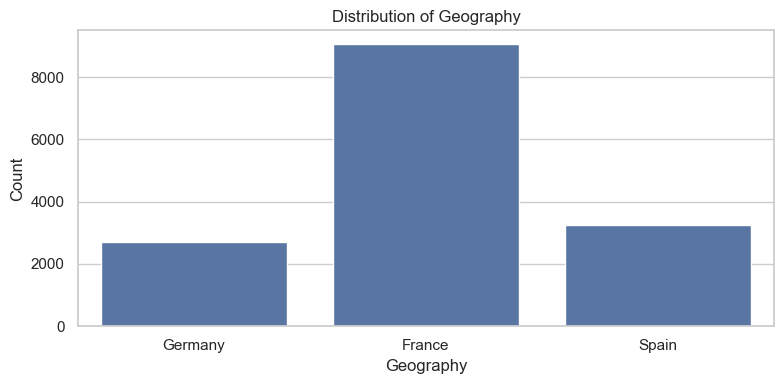

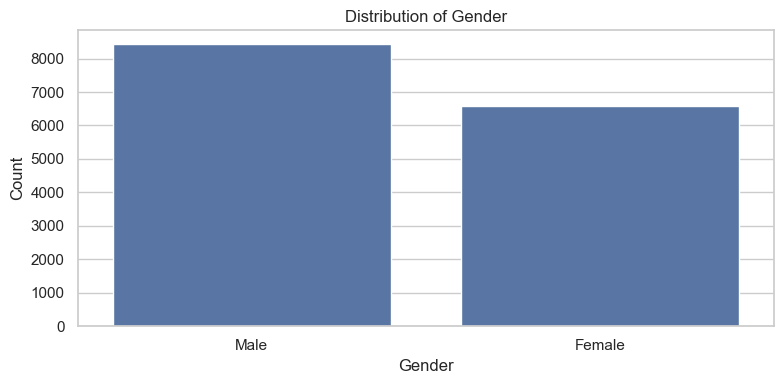

In [28]:
# display distribution of categorical variables
for col in var_cat.columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=var_cat[col])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

### Variables Catégoriques vs Cible

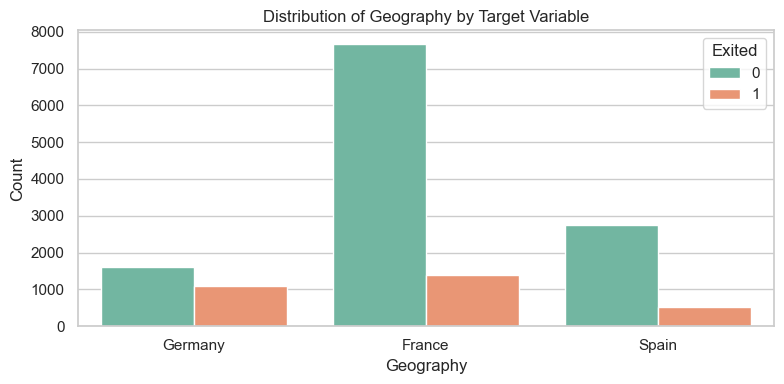

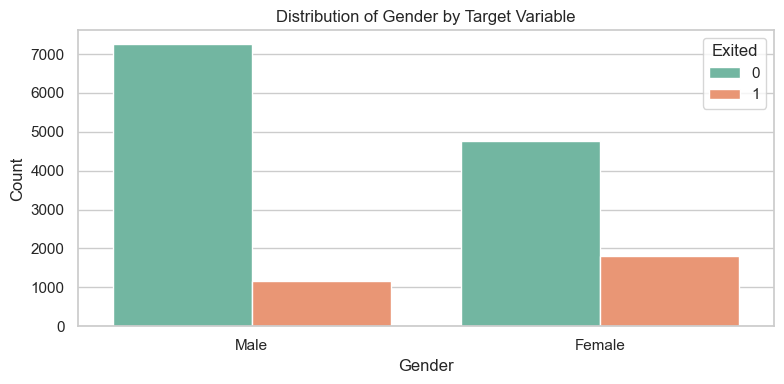

In [29]:
# display target vs categorical variables
for col in var_cat.columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=var_cat[col], hue=df_train['Exited'], palette='Set2')
    plt.title(f'Distribution of {col} by Target Variable')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## 5. Tests Statistiques d'Indépendance

### Test ANOVA (Analysis of Variance)

#### Théorème (ANOVA - F-test):

L'**ANOVA** teste l'hypothèse d'égalité des moyennes entre plusieurs groupes.

**Hypothèses du test:**
- **H₀**: Toutes les moyennes de groupe sont égales: $\mu_1 = \mu_2 = ... = \mu_k$
- **H₁**: Au moins une moyenne est différente

**Statistique du test (F-statistic):**
$$F = \frac{\text{Variance Between Groups}}{\text{Variance Within Groups}} = \frac{MS_B}{MS_W}$$

**Règle de décision:**
- Si **p-value < 0.05** → **Rejeter H₀** → Les groupes ont des moyennes significativement **différentes**
- Si **p-value ≥ 0.05** → **Ne pas rejeter H₀** → Les groupes ont des moyennes similaires

**Interprétation pour la classification:**
- Variable avec p-value < 0.05 → Variable discriminante 
- Variable avec p-value ≥ 0.05 → Variable non-discriminante

In [30]:
# ANOVA test for categorical variables vs target variable


anova_cat_results = []

for col in var_cat.columns:
    # Get unique categories
    categories = df_train[col].unique()
    
    # Create groups for each category
    groups = []
    for cat in categories:
        # Get target values for this category
        group_values = df_train['Exited'][df_train[col] == cat].values
        groups.append(group_values)
    
    try:
        # Perform ANOVA test
        f_stat, p_value = f_oneway(*groups)
        
        # Determine significance
        is_significant = "Yes" if p_value < 0.05 else "No"
        
        anova_cat_results.append([col, f_stat, p_value, is_significant])
    except Exception as e:
        anova_cat_results.append([col, np.nan, np.nan, "Error"])

# Create results DataFrame
anova_cat_df = pd.DataFrame(anova_cat_results, columns=["Variable", "F_statistic", "p_value", "Significant_0.05"])
anova_cat_df = anova_cat_df.sort_values('p_value')

anova_cat_df


,Variable,F_statistic,p_value,Significant_0.05
0,Geography,442.160826,2.632970e-187,Yes
1,Gender,441.423549,1.301466e-96,Yes


### Test du Chi-Carré (χ²) - Variables Catégoriques vs Cible

#### Théorème (Test du Chi-Carré d'Indépendance):

Le **Chi-carré** teste l'indépendance entre deux variables catégoriques.

**Hypothèses du test:**
- **H₀**: Les deux variables sont **indépendantes** (pas de relation)
- **H₁**: Les deux variables sont **associées** (relation existe)

In [31]:
# Chi-square test for categorical variables vs target variable

chi2_results = []

for col in var_cat.columns:
    # Create contingency table
    contingency_table = pd.crosstab(df_train[col], df_train['Exited'])
    
    try:
        # Perform chi-square test
        chi2_stat, p_value, dof, expected_freq = chi2_contingency(contingency_table)
        
        # Determine significance
        is_significant = "Yes" if p_value < 0.05 else "No"
        
        chi2_results.append([col, chi2_stat, p_value, dof, is_significant])
    except Exception as e:
        chi2_results.append([col, np.nan, np.nan, np.nan, "Error"])

# Create results DataFrame
chi2_df = pd.DataFrame(chi2_results, columns=["Variable", "Chi2_statistic", "p_value", "DOF", "Significant_0.05"])
chi2_df = chi2_df.sort_values('p_value')

chi2_df


,Variable,Chi2_statistic,p_value,DOF,Significant_0.05
0,Geography,835.246906,4.250488e-182,2,Yes
1,Gender,428.007589,4.411015e-95,1,Yes


### Test Chi-Carré entre Variables Catégoriques

#### Analyse de Multicolinéarité Catégorique:

**Objectif**: Identifier les **redondances** entre variables catégoriques

**Interprétation:**
- **p-value < 0.05**: Variables sont **liées** 
- **p-value ≥ 0.05**: Variables sont **indépendantes**


In [32]:
# Chi-square test between categorical variables

chi2_cat_results = []
cat_cols = list(var_cat.columns)

# Test all pairs of categorical variables
for col1, col2 in itertools.combinations(cat_cols, 2):
    contingency_table = pd.crosstab(df_train[col1], df_train[col2])
    
    try:
        # Perform chi-square test
        chi2_stat, p_value, dof, expected_freq = chi2_contingency(contingency_table)
        
        # Determine significance
        is_significant = "Yes" if p_value < 0.05 else "No"
        
        chi2_cat_results.append([f"{col1} vs {col2}", chi2_stat, p_value, dof, is_significant])
    except Exception as e:
        chi2_cat_results.append([f"{col1} vs {col2}", np.nan, np.nan, np.nan, "Error"])

# Create results DataFrame
chi2_cat_df = pd.DataFrame(chi2_cat_results, columns=["Variable Pair", "Chi2_statistic", "p_value", "DOF", "Significant_0.05"])
chi2_cat_df = chi2_cat_df.sort_values('p_value')

chi2_cat_df


,Variable Pair,Chi2_statistic,p_value,DOF,Significant_0.05
0,Geography vs Gender,9.170296,0.010202,2,Yes


In [33]:
# Average EstimatedSalary by Geography and Gender
df_train.groupby(['Geography','Gender'])['EstimatedSalary'].mean()

Geography  Gender
France     Female    117040.450698
           Male      117872.360148
Germany    Female    121082.772628
           Male      117933.927200
Spain      Female    118005.425425
           Male      117477.840339
Name: EstimatedSalary, dtype: float64

In [34]:
# Average Age by Geography and Gender
df_train.groupby(['Geography','Gender'])['Age'].mean()

Geography  Gender
France     Female    37.785223
           Male      36.680851
Germany    Female    40.270767
           Male      39.085239
Spain      Female    37.972877
           Male      36.998922
Name: Age, dtype: float64

In [35]:
# save the new dataset
#df_train.to_csv('../data/cleaned_data.csv', index=False)